In [91]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [93]:
#remove rows with outliers
data = data[data['total sulfur dioxide']<200]

In [94]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')

data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03
mean,-2.139804e-16,9.065315e-17,5.403039e-16,2.531590,-3.595190e-16,-1.897355e-16,-1.803504e-16,3.403345e-14,3.047726e-16,2.351805e-16,-7.387120e-16,7.301958e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.395974,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,0.900000,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,-3.266852e+00
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,1.900000,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,-7.866225e-01
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,2.200000,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,4.534922e-01
75%,5.051954e-01,6.253377e-01,7.695258e-01,2.600000,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,4.534922e-01
max,4.352281e+00,5.878672e+00,3.754246e+00,15.500000,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,2.933721e+00


In [95]:
N = data['residual sugar'].shape[0]
index2miss = np.random.randint(0,N-1,10)

testdata = data.loc[index2miss]
traindata = data.drop(list(index2miss))
testkeep = testdata[['residual sugar']]

testdata['residual sugar'] = np.nan
print(f'Total data size is {N}')
print(f'Train data size and test data size added: {traindata.shape[0] + testdata.shape[0]}')
testdata

Total data size is 1597
Train data size and test data size added: 1597


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1063,1.079387,-1.330691,1.953122,NaN,-0.265897,-0.943698,-0.916849,-0.584595,-0.593837,-0.167185,1.296487,0.453492
1314,-0.758027,-0.939485,-0.311149,NaN,-0.032159,0.781204,0.717522,-0.632375,0.574491,-0.757229,-0.301367,0.453492
1144,-0.585769,-1.163031,-0.208227,NaN,-0.457137,1.835312,0.748952,-0.462491,0.769213,-0.226190,-0.301367,-0.786623
1240,-0.470931,0.457678,-0.362609,NaN,-0.244648,1.931139,0.434650,-0.961523,-1.372723,-1.524287,-1.053298,-0.786623
1394,-1.102542,0.234132,-0.671373,NaN,-0.372141,1.068688,0.843243,-0.032475,0.055234,-1.052251,-1.147290,-0.786623
463,-0.126416,0.737111,2.210425,NaN,0.222827,0.877032,2.603334,0.238277,-1.502537,-0.757229,-1.335272,-0.786623
1049,0.562615,-0.157074,0.460762,NaN,-0.074657,-0.943698,-0.916849,0.153335,-0.269302,0.658876,0.356573,0.453492
19,-0.241254,-1.163031,1.232672,NaN,5.386301,0.110409,0.308929,0.079011,-1.762166,2.488013,-1.147290,0.453492
268,-0.815446,0.066472,-1.185980,NaN,-0.223399,-0.847870,-0.602547,1.034604,2.456798,1.484938,-0.959307,0.453492
177,-0.470931,-0.045301,0.769526,NaN,-0.010911,-0.752042,-0.256814,0.238277,1.742820,-0.285194,0.074599,0.453492


In [96]:
testkeep

,residual sugar
1063,2.4
1314,2.4
1144,2.3
1240,1.7
1394,3.9
463,2.2
1049,1.8
19,1.8
268,3.0
177,2.3


In [97]:
dataT_train = torch.tensor( traindata[traindata.keys().drop('residual sugar')].values).float()
dataT_test = torch.tensor( testdata[testdata.keys().drop('residual sugar')].values).float()

labels_train = torch.tensor( traindata['residual sugar'].values ).float()
labels_train = labels_train[:,None]
labels_test = torch.tensor( testdata['residual sugar'].values ).float()
labels_test = labels_test[:,None]

labels_keep = torch.tensor( testkeep['residual sugar'].values ).float()

labels_keep = labels_keep[:,None]

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(dataT_train,labels_train)
test_data  = TensorDataset(dataT_test,labels_test)

# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last = True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [98]:
# create a class for the model
def createWineNet(nUnits,nLayers):

  class WineNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(11,nUnits)
      
      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,1)
    

    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )
      
      # return output layer
      x = self.layers['output'](x)
      return x
  
  # create the model instance
  net = WineNet(nUnits,nLayers)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [99]:
### a function that trains the model

# global parameter
numepochs = 100

def trainTheModel(nUnits, nLayers):

  # loss function and optimizer
  net,lossfun,optimizer = createWineNet(nUnits,nLayers)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean((torch.abs(yHat-y)<0.05).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    
    testAcc.append( 100*torch.mean((torch.abs(yHat-y)<0.05).float()).item() )
    
  
  # function output
  return trainAcc,testAcc,losses,net

In [100]:
# Test the model with fake input

nUnits = 50
nLayers = 4

net,lossf,opt = createWineNet(nUnits,nLayers)

input = torch.rand(10,11)
print(net)
net(input)

WineNet(
  (layers): ModuleDict(
    (input): Linear(in_features=11, out_features=50, bias=True)
    (hidden0): Linear(in_features=50, out_features=50, bias=True)
    (hidden1): Linear(in_features=50, out_features=50, bias=True)
    (hidden2): Linear(in_features=50, out_features=50, bias=True)
    (hidden3): Linear(in_features=50, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=1, bias=True)
  )
)


tensor([[-0.0374],
        [-0.0391],
        [-0.0353],
        [-0.0358],
        [-0.0360],
        [-0.0362],
        [-0.0342],
        [-0.0376],
        [-0.0324],
        [-0.0358]], grad_fn=<AddmmBackward0>)

In [101]:
# Run and train the model

net,lossf,opt = createWineNet(nUnits,nLayers)
trainAcc,testAcc,losses,net = trainTheModel(nUnits,nLayers)

In [102]:
net(dataT_train)
labels_train

tensor([[1.9000],
        [2.6000],
        [2.3000],
        ...,
        [2.3000],
        [2.0000],
        [3.6000]])

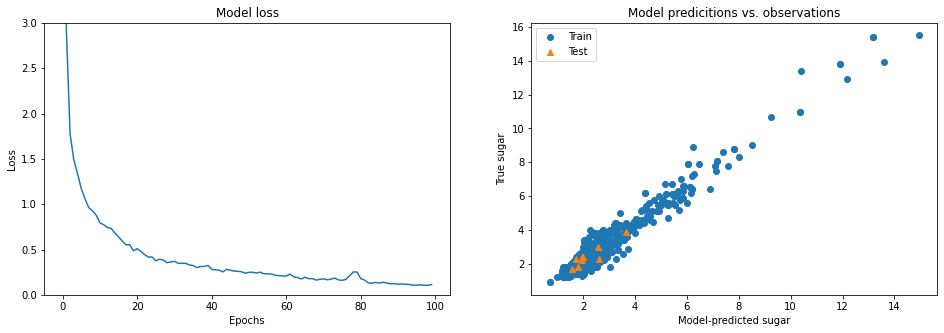

 Corr coefficient of train and test are: (0.972692056318529, 0.9145094677633179)


In [110]:
fig, ax = plt.subplots(1,2, figsize = (16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')


corrTrain = np.corrcoef(net(dataT_train).detach().T,labels_train.T)[1,0]
corrTest = np.corrcoef(net(dataT_test).detach().T,labels_keep.T)[1,0]
ax[1].plot(net(dataT_train).detach(),labels_train,'o',label='Train')
ax[1].plot(net(dataT_test).detach(),labels_keep,'^',label='Test')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predicitions vs. observations')
ax[1].legend()

plt.show()
print(f' Corr coefficient of train and test are: {corrTrain,corrTest}')
